# TCC - Helder Rezende

# Apresentação TCC

In [2]:
import pandas as pd
from datetime import datetime
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas_datareader.data as web
import seaborn as sns
import statsmodels.api as sm
from arch import arch_model
import arch
import scipy
from scipy.stats import t
from scipy.optimize import fmin
plt.style.use('ggplot')

%matplotlib inline

### Referências bibliográficas 

http://www.crest.fr/ckfinder/userfiles/files/pageperso/fermania/chapter-book-copula-density-estimation.pdf

https://risk-engineering.org/VaR/

http://www.analyticsresearch.net/Documents/2013AFEsession5.Practicals.pdf

financephd.typepad.com/files/copulas.pdf

http://www.impa.br/opencms/pt/ensino/downloads/mestrado_profissional_projeto_fim_curso/projetos_fim_cursos_2013/Cristiane_Azevedo.pdf


http://epub.lib.aalto.fi/fi/ethesis/pdf/12049/hse_ethesis_12049.pdf

financephd.typepad.com/files/copulas.pdf

### Introdução

O objetivo do trabalho primeiramente é analisar os modelos de VAR e volatilidade na crise brasileira. Primeiramente iremos listar os retornos do indice bovespa durante o periodo 1/1/2014 até 3/20/2016.

In [3]:
cotacoes_bovespa = web.DataReader('^BVSP', data_source='yahoo', start='1/1/2014', end = '3/20/2016')['Close'] # cotacoes atraves do yahoo finace
retornos_bovespa_abs = abs(cotacoes_bovespa.pct_change()).dropna() 
retornos_bovespa = cotacoes_bovespa.pct_change().dropna() 
pd.DataFrame(retornos_bovespa.sort_values()[-5:]*100) # ordena os valores e pega os 5 maiores

,Close
Date,
2015-11-03,4.763566
2014-10-13,4.782051
2014-11-21,5.020317
2016-03-03,5.123293
2016-03-17,6.597157


In [4]:
len(retornos_bovespa)

559

Percebe-se que na data 2016-03-17 teve um retorno extramamente alto. Nesse dia teve a decisao do impeachment

Testando se os retornos do Indice bovespa segue uma distribuicao normal

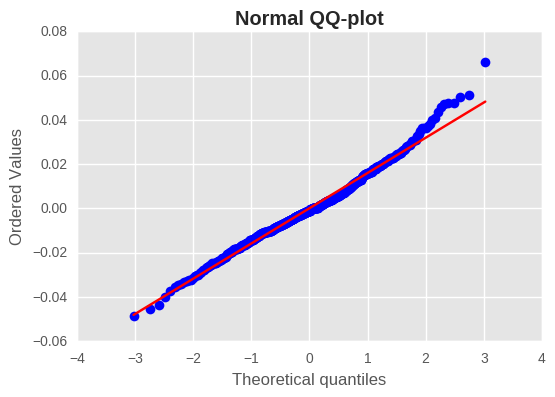

In [5]:
Q = retornos_bovespa.as_matrix()
scipy.stats.probplot(Q, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111))
plt.title(u"Normal QQ-plot", weight="bold");

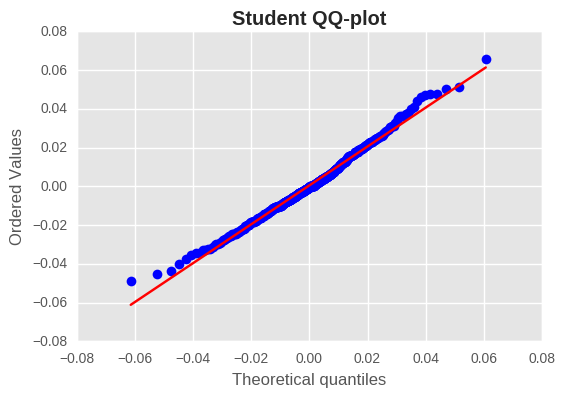

In [6]:
tdf, tmean, tsigma = scipy.stats.t.fit(Q)
scipy.stats.probplot(Q, dist=scipy.stats.t, sparams=(tdf, tmean, tsigma), plot=plt.figure().add_subplot(111))
plt.title(u"Student QQ-plot", weight="bold");

### BackTesting - Configuração

Cenários de Backtestings:

In [7]:
pd.DataFrame({"Data Inicial" : ['3/21/2015',' 3/25/2014','4/5/2012'],"Data Final" : '4/1/2016'} , index = [255,510,1000])

,Data Final,Data Inicial
255,4/1/2016,3/21/2015
510,4/1/2016,3/25/2014
1000,4/1/2016,4/5/2012


#### Kupiec Tests 

Tabela de Não-Rejeição de acordo o numero de falhas N.

In [8]:
Kupiec = pd.DataFrame(index = [0.01,0.025,0.05,0.075,0.01])

In [9]:
Kupiec["VaR"] = ["99%"," 97.5","95%", "92.5%","90%"]
Kupiec["T = 255 dias"] = ["N<7", "2<N<12", "6<N<21", "11<N<28", "16<N<36"]
Kupiec["T = 510 dias"] = ["1<N<11", "6<N<21", "16<N<36", "27<N<51", "38<N<65"]
Kupiec["T = 1000 dias"] = ["4<N<17", "15<N<36", "37<N<65", "59<N<92", "81<N<120"]

In [10]:
Kupiec

,VaR,T = 255 dias,T = 510 dias,T = 1000 dias
0.010,99%,N<7,1<N<11,4<N<17
0.025,97.5,2<N<12,6<N<21,15<N<36
0.050,95%,6<N<21,16<N<36,37<N<65
0.075,92.5%,11<N<28,27<N<51,59<N<92
0.010,90%,16<N<36,38<N<65,81<N<120


### 1 - VaR histórico

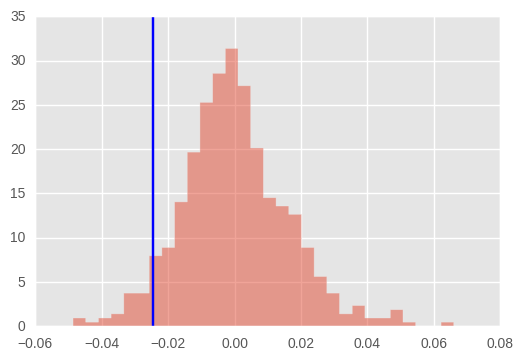

In [11]:
confianca = 0.95

retornos_bovespa.hist(bins=30,normed=True,histtype='stepfilled',alpha=0.5)

plt.axvline(x=retornos_bovespa.quantile([1-confianca,confianca])[1-confianca], color='b')

In [12]:
def var_historico(retornos, confianca):
    
    return retornos.quantile(1-confianca)
        

In [13]:
var_99_historico = retornos_bovespa.quantile(1-0.99)
var_95_historico = retornos_bovespa.quantile(1-0.95)
var_90_historico = retornos_bovespa.quantile(1-0.90)

cvar_99_historico=[]
cvar_95_historico=[]
cvar_90_historico=[]

for x in retornos_bovespa:
    if x <var_99_historico:
        cvar_99_historico.append(x)
    if x <var_95_historico:
        cvar_95_historico.append(x)
    if x <var_90_historico:
        cvar_90_historico.append(x)

    
var_historico = pd.DataFrame(index =[0.90,0.95,0.99])
var_historico['VaR(%)'] = [var_90_historico*100,var_95_historico*100,var_99_historico*100]
var_historico['CVaR(%)'] = [np.mean(cvar_90_historico)*100,np.mean(cvar_95_historico)*100,np.mean(cvar_99_historico)*100]
var_historico

,VaR(%),CVaR(%)
0.90,-1.844030,-2.662994
0.95,-2.464303,-3.180908
0.99,-3.491289,-4.173338


In [14]:
len(retornos_bovespa)

559

### 1.2 BackTesting

In [15]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
inicio = len(retornos_bovespa) - 255
final = len(retornos_bovespa)
for x in range(inicio,final):
   
    lista_var95.append(retornos_bovespa[x-255:x].quantile(0.05))
    if lista_var95[-1] > retornos_bovespa.iloc[x-1]:
        count95 += 1
    lista_var90.append(retornos_bovespa[x-255:x].quantile(0.1))
    if lista_var90[-1] > retornos_bovespa.iloc[x-1]:
        count90 += 1
    lista_var99.append(retornos_bovespa[x-255:x].quantile(0.01))
    if lista_var99[-1] > retornos_bovespa.iloc[x-1]:
        count99 += 1
    
retornos_bovespa_plot = retornos_bovespa[inicio:final]

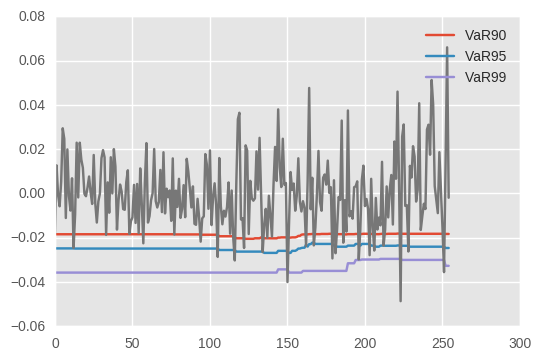

In [16]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_bovespa_plot.as_matrix())
plt.legend()

In [93]:
backtesting_historio = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 255 dias"])
backtesting_historio["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_historio

,Excecoes para 255 dias,T = 255 dias
VaR 90,26,16<N<36
VaR 95,12,6<N<21
VaR 99,3,N<7


### 2 - VaR paramétrico

#### 2.1 - Calculando a volatilidade histórica

In [95]:
volatilidade_valores = []

volatilidade_valores_com_na = pd.rolling_std(retornos_bovespa,60)
volatilidade_valores = volatilidade_valores_com_na.dropna()


volatilidade = pd.DataFrame(volatilidade_valores,columns = ["Index IBOVESPA"])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=60).std()
  app.launch_new_instance()


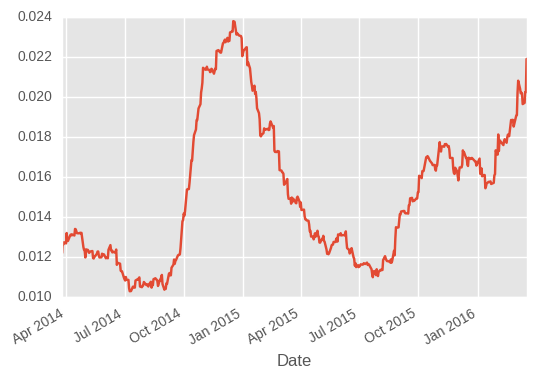

In [96]:
volatilidade_valores.plot()

#### 2.1.1 - VaR

In [97]:
var_parametrico = pd.DataFrame([1.28,1.65,2.23], index =[0.90,0.95,0.99], columns = ["Alpha"])

In [98]:
var_parametrico['VAR(%)'] = (volatilidade_valores.iloc[-1]) * var_parametrico*-100


In [99]:
var_parametrico

,Alpha,VAR(%)
0.90,1.28,-2.801302
0.95,1.65,-3.611054
0.99,2.23,-4.880394


#### 2.1.1.1 - BackTesting

In [100]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
for x in range(inicio,final):
   
    lista_var95.append(volatilidade_valores_com_na.iloc[x-1]*-1.65)
    if lista_var95[-1] > retornos_bovespa.iloc[x-1]:
        count95 += 1
        
    lista_var90.append(volatilidade_valores_com_na.iloc[x-1]*-1.28)
    if lista_var90[-1] > retornos_bovespa.iloc[x-1]:
        count90 += 1
        
    lista_var99.append(volatilidade_valores_com_na.iloc[x-1]*-2.23)
    if lista_var99[-1] > retornos_bovespa.iloc[x-1]:
        count99 += 1
    

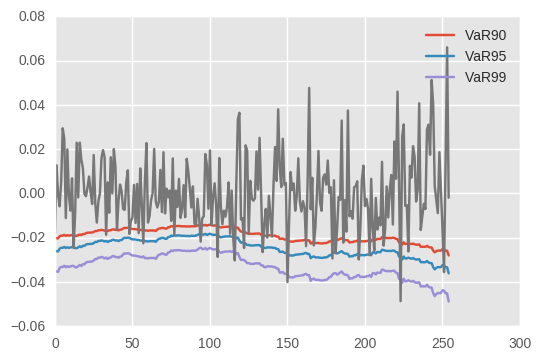

In [101]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_bovespa_plot.as_matrix())
plt.legend()

In [94]:
backtesting_parametrico = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 252 dias"])
backtesting_parametrico["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_parametrico

,Excecoes para 252 dias,T = 255 dias
VaR 90,26,16<N<36
VaR 95,12,6<N<21
VaR 99,3,N<7


#### 2.2 - Calculando a volatidade usando EWMA

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=0,span=30,ignore_na=False,adjust=True).mean()
  from ipykernel import kernelapp as app


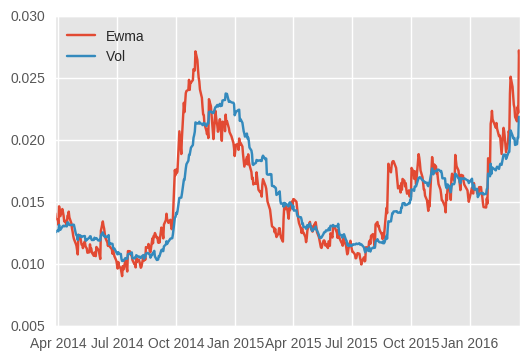

In [26]:
variance = retornos_bovespa**2
ewma_variance = pd.ewma(variance, span = 30)
volatilidade_valores_ewma = pd.DataFrame([ewma_variance]).apply(sqrt)


plt.plot(volatilidade_valores_ewma[60:], label = 'Ewma')
plt.plot(volatilidade_valores, label = 'Vol')
plt.legend(loc = 2)

#### 2.2.1 - BackTesting

In [27]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
for x in range(inicio,final):
   
    lista_var95.append(volatilidade_valores_ewma.iloc[x-1]*-1.65)
    if lista_var95[-1] > retornos_bovespa.iloc[x-1]:
        count95 += 1
        
    lista_var90.append(volatilidade_valores_ewma.iloc[x-1]*-1.28)
    if lista_var90[-1] > retornos_bovespa.iloc[x-1]:
        count90 += 1
        
    lista_var99.append(volatilidade_valores_ewma.iloc[x-1]*-2.23)
    if lista_var99[-1] > retornos_bovespa.iloc[x-1]:
        count99 += 1

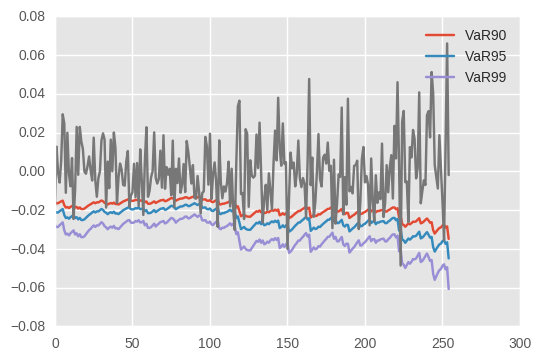

In [28]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_bovespa_plot.as_matrix())
plt.legend()

In [135]:
backtesting_parametrico_ewma = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 252 dias"])

backtesting_parametrico_ewma["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_parametrico_ewma

,Excecoes para 252 dias,T = 255 dias
VaR 90,29,16<N<36
VaR 95,13,6<N<21
VaR 99,4,N<7


#### 2.2.1 - VaR

In [30]:
var_parametrico_ewma = pd.DataFrame([1.28,1.65,2.23], index =[0.90,0.95,0.99],columns = ["Alpha"])

In [31]:
var_parametrico_ewma['VAR(%)'] = (volatilidade_valores_ewma[-1]) * var_parametrico_ewma *100

In [32]:
var_parametrico_ewma

,Alpha,VAR(%)
0.90,1.28,3.373924
0.95,1.65,4.349198
0.99,2.23,5.878008


#### 2.3 - Calculando a volatidade usando GARCH(1,1)

In [33]:
am = arch_model(retornos_bovespa)
res = am.fit(update_freq=5)
volatilidade_valores_garch = res.conditional_volatility

Iteration:      5,   Func. Count:     53,   Neg. LLF: -1544.0069406109908
Iteration:     10,   Func. Count:     96,   Neg. LLF: -1544.6386717481437
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1544.67680873
            Iterations: 14
            Function evaluations: 134
            Gradient evaluations: 14


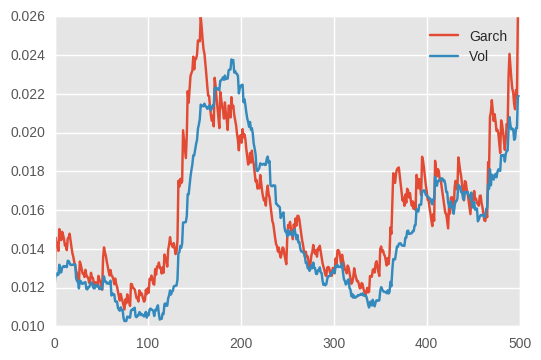

In [34]:
plt.plot(volatilidade_valores_garch.as_matrix()[60:], label='Garch')
plt.plot(volatilidade_valores.as_matrix(), label = 'Vol')
plt.legend()

#### 2.3.1 - VaR

In [35]:
var_parametrico_garch = pd.DataFrame([1.28,1.65,2.23], index =[0.90,0.95,0.99],columns = ["Alpha"])
var_parametrico_garch['VAR(%)'] = (volatilidade_valores_garch[-1]) * var_parametrico_garch *100
var_parametrico_garch

,Alpha,VAR(%)
0.90,1.28,3.324362
0.95,1.65,4.285310
0.99,2.23,5.791662


#### 2.3.2 - BackTesting

In [137]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
for x in range(inicio,final):
   
    lista_var95.append(volatilidade_valores_garch.iloc[x-1]*-1.65)
    if lista_var95[-1] > retornos_bovespa.iloc[x-1]:
        count95 += 1
        
    lista_var90.append(volatilidade_valores_garch.iloc[x-1]*-1.28)
    if lista_var90[-1] > retornos_bovespa.iloc[x-1]:
        count90 += 1
        
    lista_var99.append(volatilidade_valores_garch.iloc[x-1]*-2.23)
    if lista_var99[-1] > retornos_bovespa.iloc[x-1]:
        count99 += 1

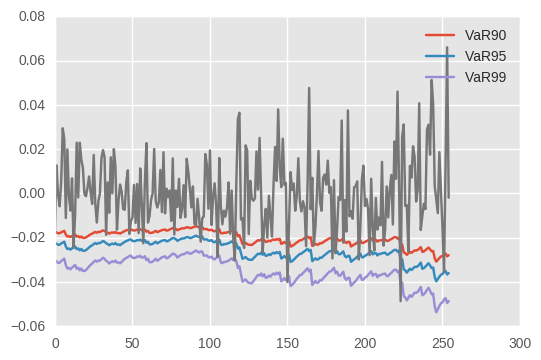

In [138]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_bovespa_plot.as_matrix())
plt.legend()

In [139]:
backtesting_parametrico_garch = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 252 dias"])
backtesting_parametrico_garch["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_parametrico_garch

,Excecoes para 252 dias,T = 255 dias
VaR 90,26,16<N<36
VaR 95,12,6<N<21
VaR 99,3,N<7


### 3 - VaR Monte Carlo

In [140]:
def random_walk(cotacoes):
    retornos = cotacoes.pct_change().dropna() 
    days = 2
    dt = 1/float(days)
    sigma = retornos.std()
    mu = retornos.mean()
    startprice = cotacoes[-1]
    
    price = np.zeros(days)
    shock = np.zeros(days)
    price[0] = startprice
    for i in range(1, days):
        shock[i] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        price[i] = max(0, price[i-1] + shock[i] * price[i-1])
    return price

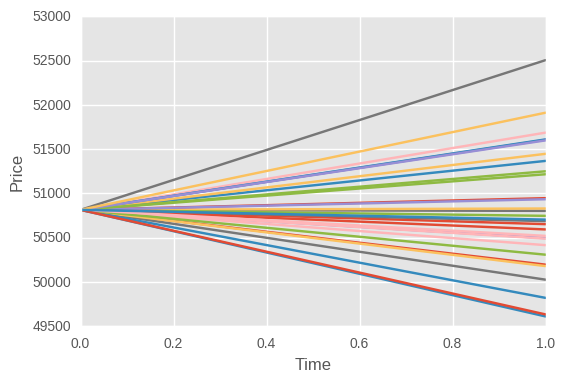

In [40]:
for run in range(30):
    plt.plot(random_walk(cotacoes_bovespa))
plt.xlabel("Time")
plt.ylabel("Price");

#### 3.1 - VaR

In [41]:
runs = 10000
simulations = []
for run in range(runs):
    simulations.append(random_walk(cotacoes_bovespa)[-1])
simulations = pd.DataFrame([simulations]).transpose()

In [42]:
var_99_montecarlo = simulations.quantile([0.01,0.99])[0][0.01]
var_95_montecarlo = simulations.quantile([0.05,0.95])[0][0.05]
var_90_montecarlo = simulations.quantile([0.1,0.9])[0][0.1]

In [43]:
var_historico = pd.DataFrame(index =[0.90,0.95,0.99])
var_historico['VaR(%)'] = [var_90_historico*100,var_95_historico*100,var_99_historico*100]

In [44]:
var_historico

,VaR(%)
0.90,-1.844030
0.95,-2.464303
0.99,-3.491289


### 3.2 - BackTesting

In [45]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
for x in range(inicio,final):
   
    lista_var95.append(volatilidade_valores_garch.iloc[x-1]*-1.65)
    if lista_var95[-1] > retornos_bovespa.iloc[x-1]:
        count95 += 1
        
    lista_var90.append(volatilidade_valores_garch.iloc[x-1]*-1.28)
    if lista_var90[-1] > retornos_bovespa.iloc[x-1]:
        count90 += 1
        
    lista_var99.append(volatilidade_valores_garch.iloc[x-1]*-2.23)
    if lista_var99[-1] > retornos_bovespa.iloc[x-1]:
        count99 += 1

### Using Extreme Value Theory and Copulas to Evaluate Market Risk

<img src="image.JPG">



This example shows how to model the market risk of a hypothetical global equity index portfolio with a Monte Carlo simulation technique using a Student's t copula and Extreme Value Theory (EVT). The process first extracts the filtered residuals from each return series with an asymmetric GARCH model, then constructs the sample marginal cumulative distribution function (CDF) of each asset using a Gaussian kernel estimate for the interior and a generalized Pareto distribution (GPD) estimate for the upper and lower tails. A Student's t copula is then fit to the data and used to induce correlation between the simulated residuals of each asset. Finally, the simulation assesses the Value-at-Risk (VaR) of the hypothetical global equity portfolio over a one month horizon.

Note that this is a relatively advanced, comprehensive example that assumes some familiarity with EVT and copulas. For details regarding estimation of generalized Pareto distributions and copula simulation, see the Modelling Tail Data with the Generalized Pareto Distribution and Simulating Dependent Random Variables Using Copulas in the Statistics and Machine Learning Toolbox™. For details regarding the approach upon which most of this example is based, see references [5] and [6] by Nystrom and Skoglund in the bibliography.


In [46]:
iniditalDate = "1/1/2016"
ativos = ['ABEV3', 'PETR4','RADL3','BBDC4']
N = len(ativos)

In [47]:
cotacoesAmbev = web.DataReader('ABEV3.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesPetr = web.DataReader('PETR4.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesRadl = web.DataReader('RADL3.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesBbdc = web.DataReader('BBDC4.SA', data_source='yahoo', start=iniditalDate)['Close']


In [48]:
cotacoes = [cotacoesAmbev,cotacoesPetr,cotacoesRadl,cotacoesBbdc]
cotacoesPandas = pd.DataFrame(index = ativos, data = cotacoes)


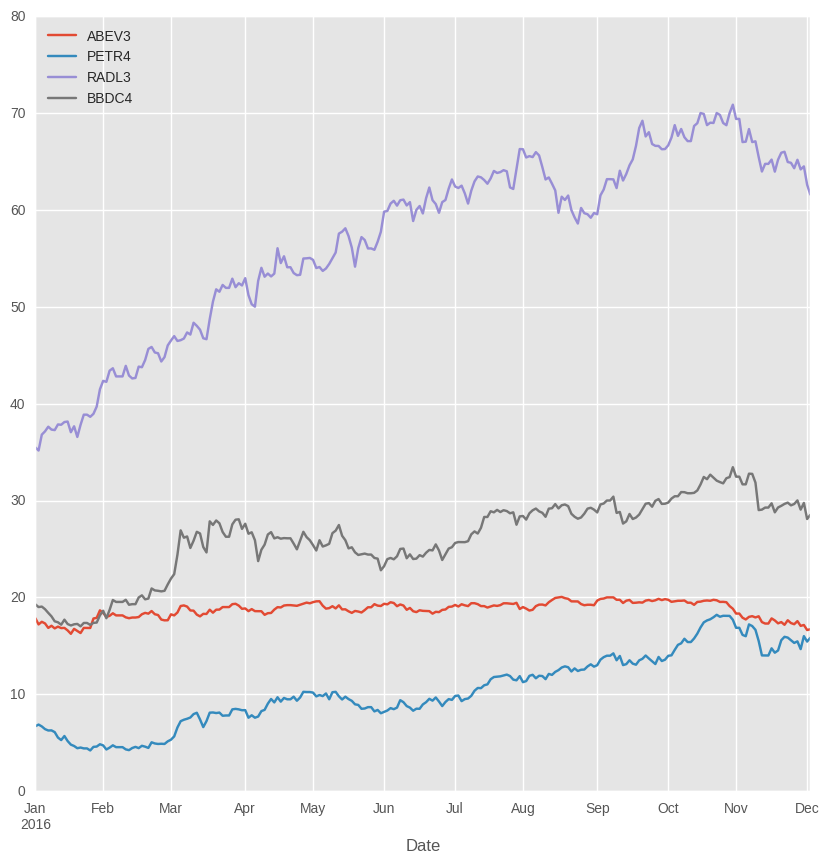

In [49]:
cotacoesPandas.transpose().dropna().plot(figsize= (10,10))

In preparation for subsequent modeling, convert the closing level of each index to daily logarithmic returns (sometimes called geometric, or continuously compounded, returns).

In [50]:
def logReturn(cotacoes):
    return np.log((cotacoes / cotacoes.shift(1)))[1:]

Since the first step in the overall modeling approach involves a repeated application of GARCH filtration and Extreme Value Theory to characterize the distribution of each individual equity index return series, it is helpful to examine the details for a particular country. You can change the next line of code to any integer in the set {1,2,3,4,5,6} to examine the details for any index.

In [51]:
returns = [logReturn(cotacoes[x]) for x in range(len(cotacoes))]
returnsPandas = pd.DataFrame(index = ativos, data = returns)
returnsPandas = returnsPandas.transpose().dropna()

In [52]:
returnsPandas.corr()

,ABEV3,PETR4,RADL3,BBDC4
ABEV3,1.000000,0.373955,0.276461,0.382949
PETR4,0.373955,1.000000,0.310553,0.638732
RADL3,0.276461,0.310553,1.000000,0.332087
BBDC4,0.382949,0.638732,0.332087,1.000000


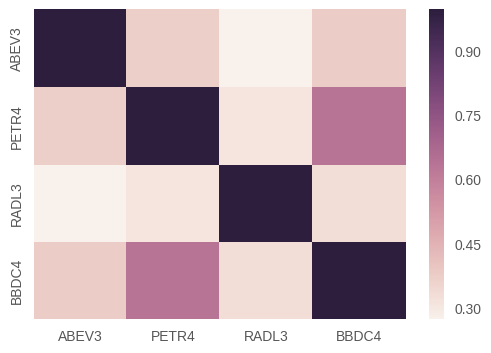

In [53]:
corr = returnsPandas.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

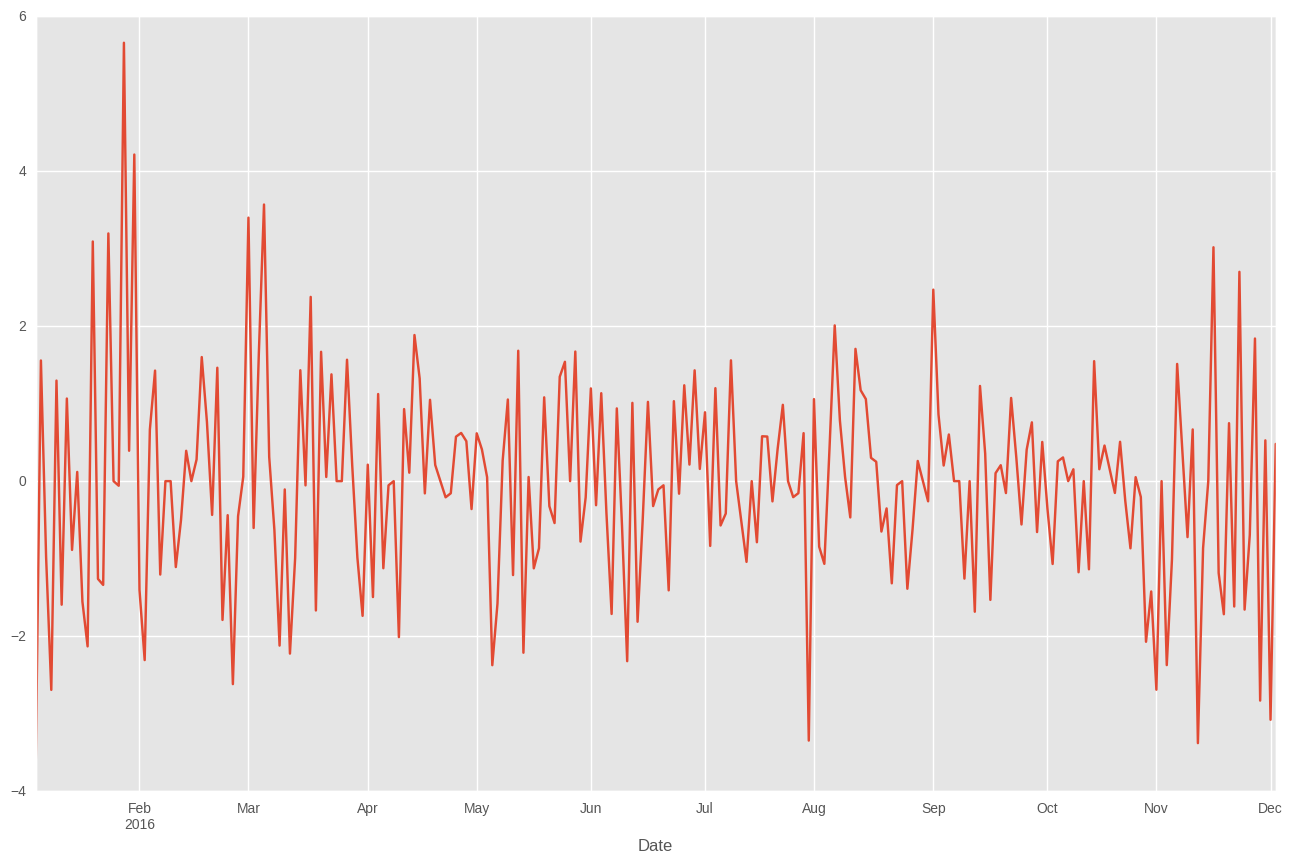

In [54]:
(returnsPandas["ABEV3"]*100).plot(figsize=(16,10))

## Filter the Returns for Each Index

Fonte de estudo para essa parte: https://www.otexts.org/fpp/8/3
https://pypi.python.org/pypi/arch/3.0#bootstrap

Modeling the tails of a distribution with a GPD requires the observations to be approximately independent and identically distributed (i.i.d.). However, most financial return series exhibit some degree of autocorrelation and, more importantly, heteroskedasticity.

For example, the sample autocorrelation function (ACF) of the returns associated with the selected index reveal some mild serial correlation.

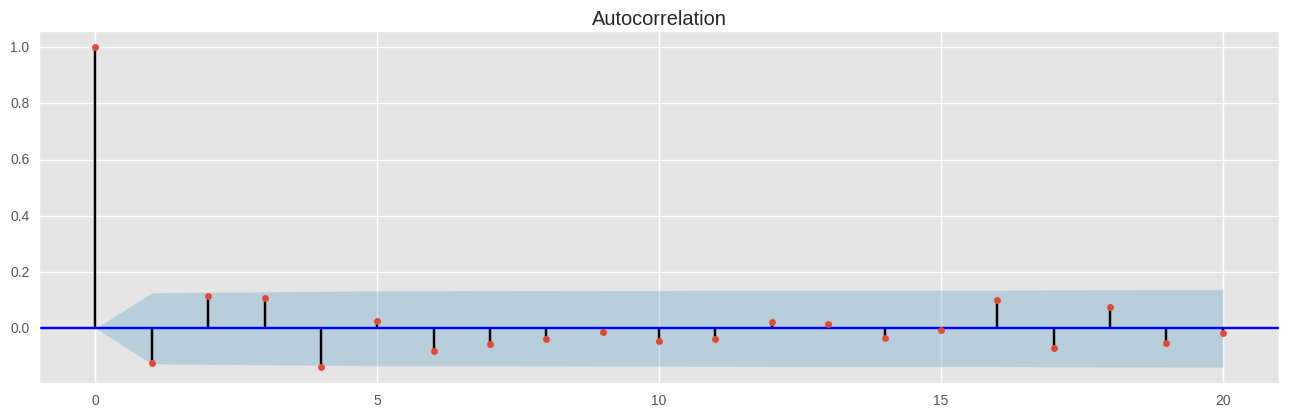

In [55]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(returnsPandas["ABEV3"], lags=20, ax=ax1)

However, the sample ACF of the squared returns illustrates the degree of persistence in variance, and implies that GARCH modeling may significantly condition the data used in the subsequent tail estimation process.

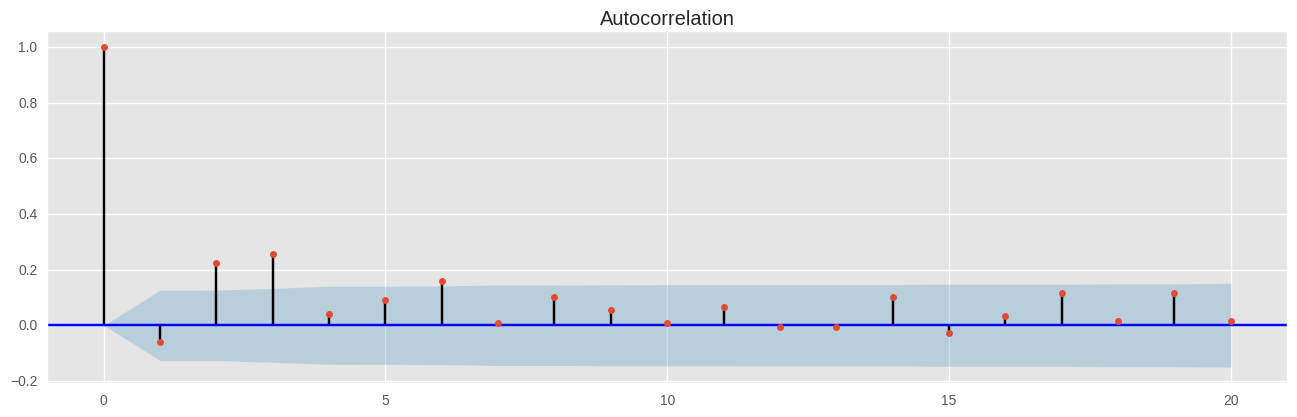

In [56]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(returnsPandas["ABEV3"]**2, lags=20, ax=ax1)

To produce a series of i.i.d. observations, fit a first order autoregressive model to the conditional mean of the returns of each equity index

$$r_t = c + \theta r_{t-1} + \epsilon_t$$

and an asymmetric GARCH model to the conditional variance

$$\sigma^2_t = \kappa + \alpha\sigma^2_{t-1} + \phi\epsilon^2_{t-1} + \psi[\epsilon_{t-1}<0]\epsilon^2_{t-1}$$

The first order autoregressive model compensates for autocorrelation, while the GARCH model compensates for heteroskedasticity. In particular, the last term incorporates asymmetry (leverage) into the variance by a Boolean indicator that takes the value 1 if the prior model residual is negative and 0 otherwise (see Glosten, Jagannathan, & Runkle [3]).

Additionally, the standardized residuals of each index are modeled as a standardized Student's t distribution to compensate for the fat tails often associated with equity returns. That is

$$z_t = \epsilon_t/\sigma_t$$ i.i.d. distributed $$t(\nu)$$

The following code segment extracts the filtered residuals and conditional variances from the returns of each equity index.

Pacote python utilizado http://arch.readthedocs.io/en/latest/univariate/introduction.html

In [57]:
arch_model_fit = []

for x in range(N):
    arch_model_fit.append(arch.arch_model(returnsPandas.ix[:,x], mean='AR', vol='GARCH', dist = 'StudentsT').fit())

Iteration:      1,   Func. Count:      7,   Neg. LLF: -711.9865990170917
Iteration:      2,   Func. Count:     24,   Neg. LLF: -712.0331360803303
Iteration:      3,   Func. Count:     41,   Neg. LLF: -712.0346380945905
Iteration:      4,   Func. Count:     53,   Neg. LLF: -712.0372587500295
Iteration:      5,   Func. Count:     67,   Neg. LLF: -712.039171039401
Iteration:      6,   Func. Count:     83,   Neg. LLF: -712.0391910140718
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -712.039191017
            Iterations: 8
            Function evaluations: 94
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      7,   Neg. LLF: -442.128651056748
Iteration:      2,   Func. Count:     21,   Neg. LLF: -442.18327952549066
Iteration:      3,   Func. Count:     34,   Neg. LLF: -442.1834787993489
Iteration:      4,   Func. Count:     44,   Neg. LLF: -442.2832542033771
Iteration:      5,   Func. Count:     53,   Neg. LLF: -442.2859136

/usr/local/lib/python3.5/dist-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/arch/univariate/base.py:510: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [58]:
parametros = pd.DataFrame()
residuos = pd.DataFrame()
volatilidade_condicional = pd.DataFrame()

for x in range(N):
    parametros[ativos[x]] = arch_model_fit[x].params
    volatilidade_condicional[ativos[x]] = arch_model_fit[x].conditional_volatility
    residuos[ativos[x]] = arch_model_fit[x].resid

residuos_normalizados = residuos/volatilidade_condicional

For the selected index, compare the model residuals and the corresponding conditional standard deviations filtered from the raw returns. The lower graph clearly illustrates the variation in volatility (heteroskedasticity) present in the filtered residuals.

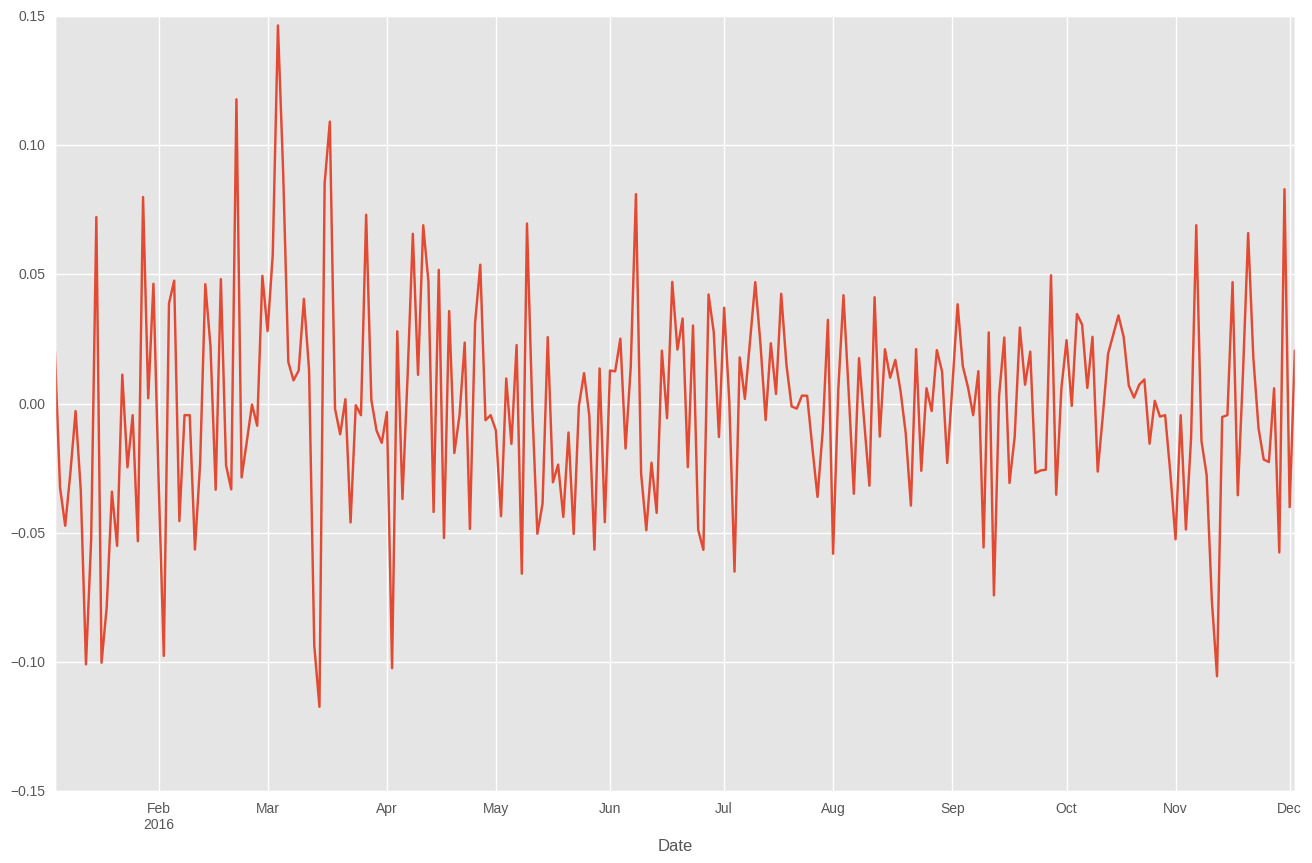

In [59]:
residuos.ix[:,1].plot(figsize=(16,10))

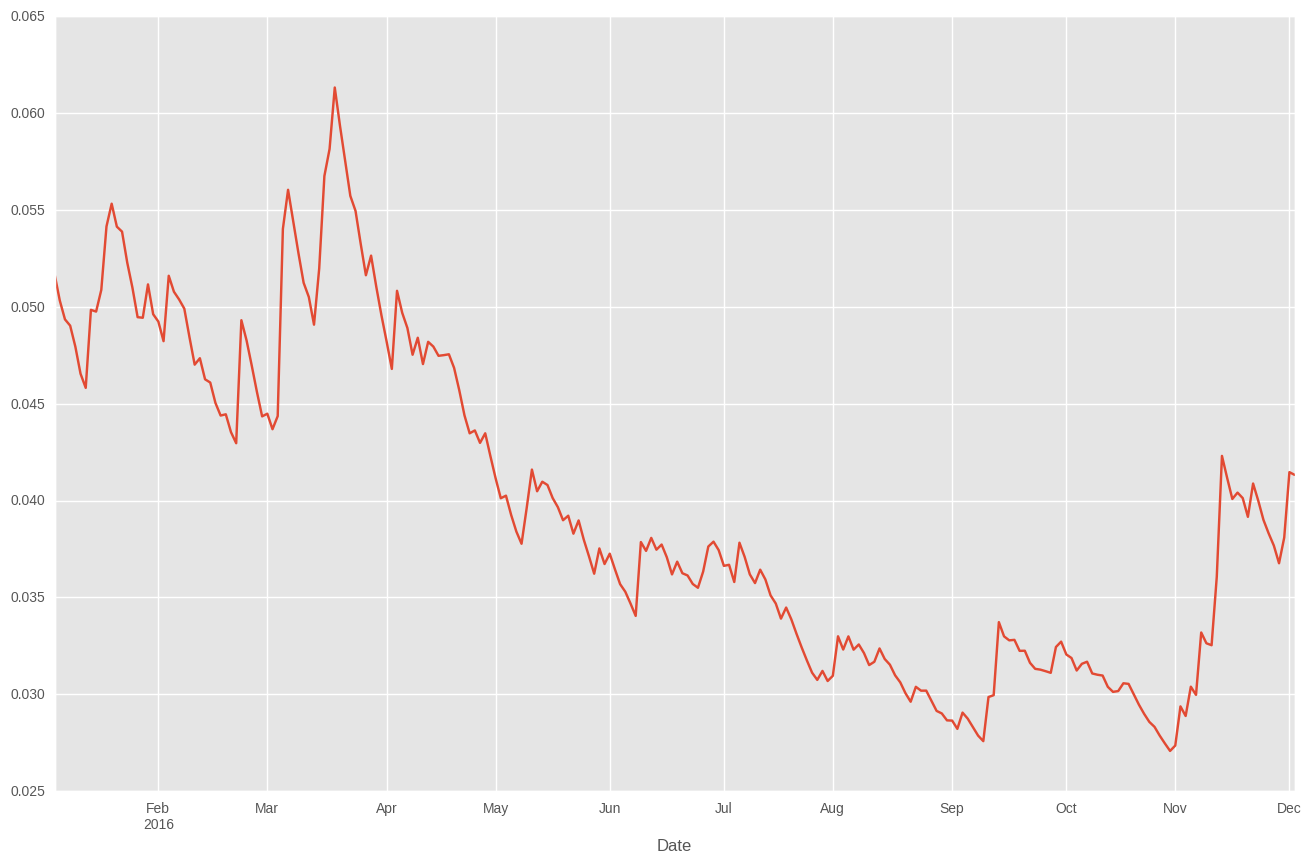

In [60]:
volatilidade_condicional.ix[:,1].plot(figsize=(16,10))

Having filtered the model residuals from each return series, standardize the residuals by the corresponding conditional standard deviation. These standardized residuals represent the underlying zero-mean, unit-variance, i.i.d. series upon which the EVT estimation of the sample CDF tails is based.

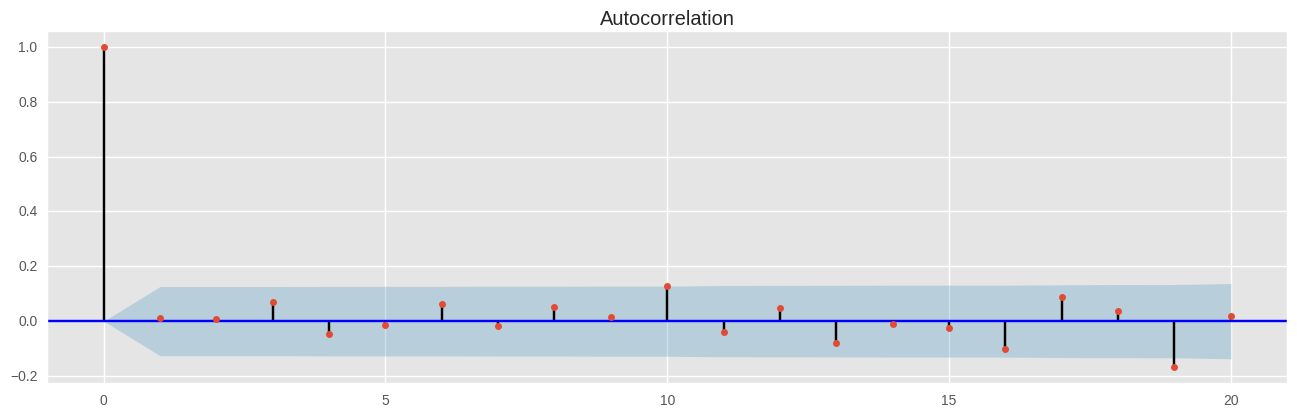

In [61]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuos_normalizados.ix[:,1], lags=20, ax=ax1)

Estimate the Semi-Parametric CDFs

In [62]:
uniforms = pd.DataFrame()
for x in range(N):
    uniforms[ativos[x]] = t.cdf(residuos_normalizados[ativos[x]],parametros[ativos[x]]['nu'])

In [63]:
uniforms.corr()

,ABEV3,PETR4,RADL3,BBDC4
ABEV3,1.000000,0.361304,0.252110,0.374524
PETR4,0.361304,1.000000,0.315425,0.622002
RADL3,0.252110,0.315425,1.000000,0.402917
BBDC4,0.374524,0.622002,0.402917,1.000000


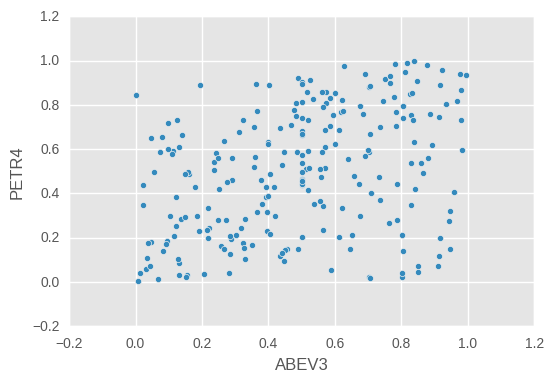

In [64]:
uniforms.ix[:,:2].plot(kind = 'scatter', x= 0, y = 1)

In [65]:
uniforms.to_csv('uniforms.csv')

### Simulandos os valores com a Copula simulada

### Calculando os valores ótimos

Nessa parte foi usado a função fitCopula do R

library(copula)

library(zoo)

uniform <- read.zoo("C:\\Users\\g4u55\\Downloads\\TCC-master\\TCC-master\\uniforms.csv",header = TRUE, sep = ",")

uniform = as.matrix(uniform)

set.seed(500)

tcop <- tCopula(dim = 4,dispstr = "un")

fit.t <- fitCopula(tcop, uniform, method="ml")

write.csv(coef(fit.t), file = "c://ParametrosOtimo.csv")

In [66]:
paramaros_otimos = pd.read_csv('ParametrosOtimo.csv')
paramaros_otimos = paramaros_otimos.drop('Unnamed: 0', 1)
paramaros_otimos

,x
0,0.450587
1,0.320444
2,0.474678
3,0.405968
4,0.712660
5,0.467890
6,6.261725


Utilizei a função rCopula do R

u <- rCopula(3965,tCopula(dim=4,dispstr = "un",coef(fit.t)[1:6],df=coef(fit.t)[7]))

write.csv(u, file = "c://CopulaOtimaSimulada.csv")

In [67]:
simulados = pd.read_csv('CopulaOtimaSimulada.csv')
simulados = simulados.drop('Unnamed: 0', 1)

In [71]:
simulados.corr()

,V1,V2,V3,V4
V1,1.000000,0.432235,0.266800,0.444507
V2,0.432235,1.000000,0.364509,0.681779
V3,0.266800,0.364509,1.000000,0.403415
V4,0.444507,0.681779,0.403415,1.000000


/usr/local/lib/python3.5/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.5/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


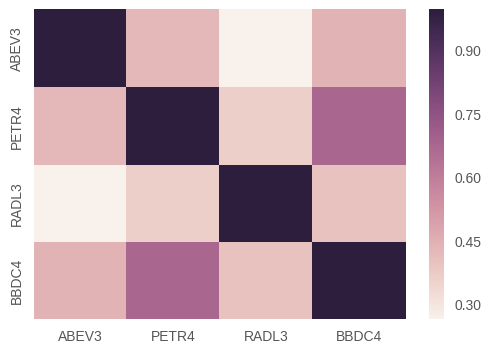

In [73]:
sns.heatmap(simulados.corr(), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [70]:
simulados.head()

,V1,V2,V3,V4
0,0.959884,0.990014,0.949032,0.924588
1,0.862362,0.502293,0.822147,0.776830
2,0.318489,0.271095,0.065277,0.056794
3,0.116601,0.276618,0.021025,0.039099
4,0.664528,0.617931,0.777534,0.821698


In [125]:
simulado_final = pd.DataFrame()

for x in range(N):
    simulado_final[ativos[x]] = t.ppf(simulados['V'+str(x+1)], parametros[ativos[x]]['nu'], loc=0, scale=1)

In [126]:
simulado_final = simulado_final*volatilidade_condicional[-1:].iloc[0]*100

In [131]:
simulado_final.head()

,ABEV3,PETR4,RADL3,BBDC4
0,3.182883,11.081757,2.888770,5.589786
1,1.901676,0.024246,1.566917,2.786769
2,-0.804900,-2.592366,-2.647361,-6.272027
3,-2.088914,-2.520721,-3.711037,-7.162640
4,0.723927,1.268437,1.288414,3.410746


In [132]:
simulado_final_carteira = simulado_final.sum(axis=1)/4

In [134]:
simulado_final_carteira.head()

0    5.685799
1    1.569902
2   -3.079163
3   -3.870828
4    1.672881
dtype: float64

In [133]:
simulado_final_carteira.quantile(0.05)

-3.932084409076417